# kamAI

We will demonstrate a system that recognizes numbers from hand gestures.  
It is similar to the final project in Coursera's `Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization` but will be implemented using `Tensorflow 2`.  
<img src="images/hand-gestures.png">  
  
Let's start with the modules needed.

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt

## Explore the dataset

We load the dataset from the H5 files.

In [2]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")

train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('datasets/test_signs.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes

train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])).T
test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0])).T

print ("train_x's shape: " + str(train_set_x_orig.shape))
print ("train_y's shape: " + str(train_set_y_orig.shape))
print ("test_x's shape: " + str(test_set_x_orig.shape))
print ("test_y's shape: " + str(test_set_y_orig.shape))

# normalize values between 0 to 1
train_set_x_orig = train_set_x_orig / 255
test_set_x_orig = test_set_x_orig / 255

train_x's shape: (1080, 64, 64, 3)
train_y's shape: (1080, 1)
test_x's shape: (120, 64, 64, 3)
test_y's shape: (120, 1)


In the training samples, we have 1080 `64 x 64 x 3` RGB images while the test samples have 120 RGB images.  
  
Here are the images from the training set.

In [3]:
# for index in range(len(train_set_x_orig)):
#     plt.imshow(train_set_x_orig[index])
#     print("idx(" + str(index) +") y("+str(train_set_y_orig.T[0,index])+") : " + str(classes[train_set_y_orig.T[0,index]]))
#     plt.show()

Here are the images from the test set.

In [4]:
# for index in range(len(test_set_x_orig)):
#     plt.imshow(test_set_x_orig[index])
#     print("idx(" + str(index) +") y("+str(test_set_y_orig.T[0,index])+") : " + str(classes[test_set_y_orig.T[0,index]]))
#     plt.show()

## Model Creation

Let's try to create a 3-layer neural network model for this problem.  
Note that the problem now has `multiple classes for classification` which can be extended from the `binary classification` problem.  
  
This command is called first to avoid casting of float64 to float32 (Tensorflow warning).

In [12]:
tf.keras.backend.set_floatx('float64')
model_dir = 'models/initial_model'  # used for saving and loading a trained model

Similar to what we did in the cat classification problem in [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith), we will make a stack of layers using Tensorflow.  
What differs from [cAIt-sith](https://github.com/scrappycoc0/cAIth-sith) is that, the last node will require `softmax` activation function since we have a multiple classification problem.  
  
<font color='red'>Note that we did not put the `softmax` activation on purpose as we plan to use the logits output instead.</font>  
See the more helpful explanation from [Tensorflow](https://www.tensorflow.org/tutorials/quickstart/beginner) instead.

In [13]:
num_of_possible_output = 6 # 0 - 5 values using 1-hand gesture

# hyperparameters
model_struct = [(25, 'relu'), (12, 'relu')]
learning_rate = 0.0001
# dropout_rate = 0.01 # temporarily commented during troubleshooting

# create model
model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=train_set_x_orig[0].shape),
#             tf.keras.layers.Dropout(dropout_rate)    # temporarily commented during troubleshooting
        ])

# add hidden layers
for layer_param in model_struct:
    model.add(tf.keras.layers.Dense(layer_param[0], activation=layer_param[1]))
#     model.add(tf.keras.layers.Dropout(dropout_rate)) # temporarily commented during troubleshooting

# final layer for softmax regression
model.add(tf.keras.layers.Dense(num_of_possible_output))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                307225    
_________________________________________________________________
dense_4 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 78        
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


The dataset label is represented by a single value between 0 to 5 that represents the hand gestures.  
To use Tensorflow, we must do a `one hot encoding` to it.  
<img src="images/onehot.png" width="500" height="250"> 

In [14]:
# one-hot encoding for training labels
oh = tf.one_hot(train_set_y_orig, num_of_possible_output) # one hot tensor
one_hot_training_labels = oh.numpy()
print('One hot training shape: ' + str(one_hot_training_labels.shape))

# removes the unnecessary 3rd dimension after tf.one_hot()
# turns the (m x 1 x num_of_possible_output) matrix to an (m x num_of_possible_output) vector
one_hot_training_labels = one_hot_training_labels.reshape(one_hot_training_labels.shape[0], -1)
print('One hot training shape (after reshape): ' + str(one_hot_training_labels.shape))

One hot training shape: (1080, 1, 6)
One hot training shape (after reshape): (1080, 6)


Since this is a multiple classification problem, we cannot use the `Binary Cross Entropy` as a loss function.  
Instead, we can use [Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy?hl=en) or [Sparse Categorical Cross Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?hl=en).  
On the documentation itself, it says that the `Categorical Cross Entropy` expects that the labels are in `one hot encoding`.  
Since we already performed the `one hot encoding` in our labels, we might as well use the `Categorical Cross Entropy`.  
  
Note here that the `tf.nn.softmax()` converts the logits to probabilities in the prediction, so we can:
1. Use the probabilities and the loss function where the parameter `from_logits=False`, or
2. Use the logits and the loss function where the parameter `from_logits=True`

In [15]:
# loss
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# prediction
predictions = model(train_set_x_orig).numpy()

# uncomment for debugging
# idx=0
# print('true label 1st: ' + str(train_set_y_orig[idx]))
# print('one hot label shape: ' + str(one_hot_training_labels.shape))
# print('one hot label 1st: ' + str(one_hot_training_labels[idx]))
# print('prediction shape: '+ str(predictions.shape))
# print('prediction of 1st: ' + str(predictions[idx]))
# print('prediction of 1st in prob: ' + str(tf.nn.softmax(predictions[idx]).numpy()))

print('Initial loss is ' + str(loss_function(one_hot_training_labels, predictions).numpy()))

Initial loss is 1.9677259922027588


Finally, we define the optimizer and metric to have the compilation.

In [16]:
# optimizer
optim_adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# compilation
model.compile(optimizer=optim_adam, loss=loss_function, metrics=['accuracy'])

Let's start training!

In [17]:
history = model.fit(train_set_x_orig, one_hot_training_labels, epochs=500)

Epoch 1/500
34/34 [==============================] - 0s 12ms/step - loss: 1.8032 - accuracy: 0.1602
Epoch 2/500
34/34 [==============================] - 0s 12ms/step - loss: 1.7923 - accuracy: 0.1685
Epoch 3/500
34/34 [==============================] - 0s 13ms/step - loss: 1.7883 - accuracy: 0.1639
Epoch 4/500
34/34 [==============================] - 0s 15ms/step - loss: 1.7757 - accuracy: 0.1954
Epoch 5/500
34/34 [==============================] - 0s 11ms/step - loss: 1.7637 - accuracy: 0.1843
Epoch 6/500
34/34 [==============================] - 0s 13ms/step - loss: 1.7512 - accuracy: 0.1880
Epoch 7/500
34/34 [==============================] - 0s 11ms/step - loss: 1.7442 - accuracy: 0.2065
Epoch 8/500
34/34 [==============================] - 0s 12ms/step - loss: 1.7295 - accuracy: 0.2111 0s - loss: 1.7436 - accura
Epoch 9/500
34/34 [==============================] - 0s 11ms/step - loss: 1.7254 - accuracy: 0.2157
Epoch 10/500
34/34 [==============================] - 0s 12ms/step - loss

34/34 [==============================] - 0s 11ms/step - loss: 1.4033 - accuracy: 0.4352
Epoch 82/500
34/34 [==============================] - 0s 13ms/step - loss: 1.3994 - accuracy: 0.4259
Epoch 83/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3961 - accuracy: 0.4556
Epoch 84/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3934 - accuracy: 0.4407
Epoch 85/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3915 - accuracy: 0.4370
Epoch 86/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3827 - accuracy: 0.4481
Epoch 87/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3773 - accuracy: 0.4593
Epoch 88/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3766 - accuracy: 0.4380
Epoch 89/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3889 - accuracy: 0.4454
Epoch 90/500
34/34 [==============================] - 0s 11ms/step - loss: 1.3690 - accuracy: 0.4602
Epo

34/34 [==============================] - 0s 12ms/step - loss: 1.0419 - accuracy: 0.6037
Epoch 162/500
34/34 [==============================] - 0s 11ms/step - loss: 1.0285 - accuracy: 0.6250
Epoch 163/500
34/34 [==============================] - 0s 11ms/step - loss: 1.0184 - accuracy: 0.6315
Epoch 164/500
34/34 [==============================] - 0s 12ms/step - loss: 1.0096 - accuracy: 0.6370
Epoch 165/500
34/34 [==============================] - 0s 11ms/step - loss: 0.9841 - accuracy: 0.6398
Epoch 166/500
34/34 [==============================] - 0s 12ms/step - loss: 0.9614 - accuracy: 0.6583
Epoch 167/500
34/34 [==============================] - 0s 11ms/step - loss: 0.9432 - accuracy: 0.6630
Epoch 168/500
34/34 [==============================] - 0s 11ms/step - loss: 0.9363 - accuracy: 0.6583
Epoch 169/500
34/34 [==============================] - 0s 12ms/step - loss: 0.9276 - accuracy: 0.6593
Epoch 170/500
34/34 [==============================] - 0s 13ms/step - loss: 0.9199 - accuracy: 0

34/34 [==============================] - 0s 11ms/step - loss: 0.5986 - accuracy: 0.8102
Epoch 241/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5847 - accuracy: 0.8139
Epoch 242/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5752 - accuracy: 0.8324
Epoch 243/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5553 - accuracy: 0.8389
Epoch 244/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5545 - accuracy: 0.8380 0s - loss: 0.5517 - accuracy
Epoch 245/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5610 - accuracy: 0.8241
Epoch 246/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5533 - accuracy: 0.8370
Epoch 247/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5532 - accuracy: 0.8407
Epoch 248/500
34/34 [==============================] - 0s 11ms/step - loss: 0.5729 - accuracy: 0.8176
Epoch 249/500
34/34 [==============================] - 0s 11ms/step

34/34 [==============================] - 0s 11ms/step - loss: 0.3746 - accuracy: 0.8944
Epoch 321/500
34/34 [==============================] - 0s 11ms/step - loss: 0.3734 - accuracy: 0.8917
Epoch 322/500
34/34 [==============================] - 0s 11ms/step - loss: 0.3777 - accuracy: 0.8981
Epoch 323/500
34/34 [==============================] - 0s 13ms/step - loss: 0.3758 - accuracy: 0.8907
Epoch 324/500
34/34 [==============================] - 0s 14ms/step - loss: 0.3760 - accuracy: 0.8991
Epoch 325/500
34/34 [==============================] - 0s 14ms/step - loss: 0.3666 - accuracy: 0.8981
Epoch 326/500
34/34 [==============================] - 0s 13ms/step - loss: 0.3733 - accuracy: 0.8954
Epoch 327/500
34/34 [==============================] - 0s 11ms/step - loss: 0.3706 - accuracy: 0.8917
Epoch 328/500
34/34 [==============================] - 0s 11ms/step - loss: 0.3772 - accuracy: 0.8944
Epoch 329/500
34/34 [==============================] - 0s 11ms/step - loss: 0.3831 - accuracy: 0

34/34 [==============================] - 0s 11ms/step - loss: 0.2689 - accuracy: 0.9287
Epoch 401/500
34/34 [==============================] - 0s 11ms/step - loss: 0.2731 - accuracy: 0.9269
Epoch 402/500
34/34 [==============================] - 0s 11ms/step - loss: 0.2743 - accuracy: 0.9259
Epoch 403/500
34/34 [==============================] - 0s 11ms/step - loss: 0.2739 - accuracy: 0.9296
Epoch 404/500
34/34 [==============================] - 0s 11ms/step - loss: 0.2741 - accuracy: 0.9259
Epoch 405/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2761 - accuracy: 0.9278
Epoch 406/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2717 - accuracy: 0.9343
Epoch 407/500
34/34 [==============================] - 1s 15ms/step - loss: 0.2593 - accuracy: 0.9398
Epoch 408/500
34/34 [==============================] - 1s 15ms/step - loss: 0.2600 - accuracy: 0.9324
Epoch 409/500
34/34 [==============================] - 0s 12ms/step - loss: 0.2581 - accuracy: 0

34/34 [==============================] - 0s 12ms/step - loss: 0.1856 - accuracy: 0.9620
Epoch 481/500
34/34 [==============================] - 0s 13ms/step - loss: 0.1955 - accuracy: 0.9528
Epoch 482/500
34/34 [==============================] - 0s 12ms/step - loss: 0.1903 - accuracy: 0.9593
Epoch 483/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1986 - accuracy: 0.9472
Epoch 484/500
34/34 [==============================] - 0s 14ms/step - loss: 0.1944 - accuracy: 0.9519
Epoch 485/500
34/34 [==============================] - 0s 11ms/step - loss: 0.1940 - accuracy: 0.9556
Epoch 486/500
34/34 [==============================] - 0s 12ms/step - loss: 0.1840 - accuracy: 0.9565
Epoch 487/500
34/34 [==============================] - 0s 13ms/step - loss: 0.1810 - accuracy: 0.9639
Epoch 488/500
34/34 [==============================] - 0s 11ms/step - loss: 0.1824 - accuracy: 0.9648
Epoch 489/500
34/34 [==============================] - 0s 11ms/step - loss: 0.1785 - accuracy: 0

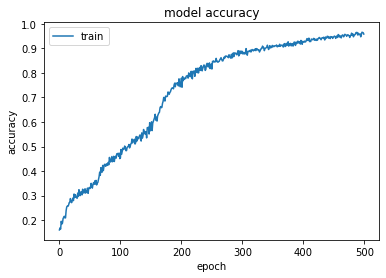

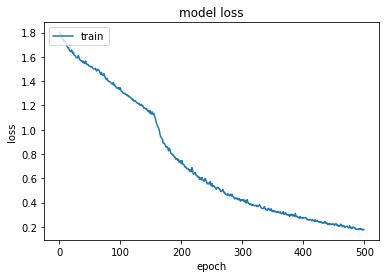

In [18]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()